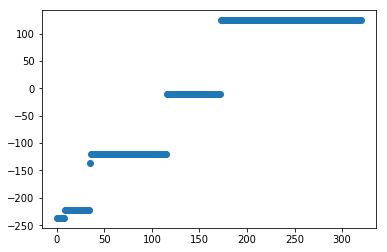

In [12]:
# %load marsland/genetic.py
# The Genetic algorithm
import numpy as np
import warnings
warnings.filterwarnings('ignore')

class ga:

    def __init__(self,stringLength,fitnessFunction,nEpochs,populationSize=100,mutationProb=-1,crossover='un',nElite=4,tournament=False):
        """ Constructor"""
        self.stringLength = stringLength
        
        # Population size should be even
        if np.mod(populationSize,2)==0:
            self.populationSize = populationSize
        else:
            self.populationSize = populationSize+1
        
        if mutationProb < 0:
             self.mutationProb = 1/stringLength
        else:
             self.mutationProb = mutationProb
                  
        self.nEpochs = nEpochs

        self.fitnessFunction = fitnessFunction

        self.crossover = crossover
        self.nElite = nElite
        self.tournament_switch = tournament

        self.population = np.random.rand(self.populationSize,self.stringLength)
        self.population = np.where(self.population<0.5,0,1)

        # print(self.population)
        
    def runGA(self,plotfig):
        """The basic loop"""
        pl.ion()
        #plotfig = pl.figure()
        bestfit = np.zeros(self.nEpochs)

        for i in range(self.nEpochs):

            # Compute fitness of the population
            fitness = eval(self.fitnessFunction)(self.population)

            # Pick parents -- can do in order since they are randomised
            newPopulation = self.fps(self.population,fitness)

            # Apply the genetic operators
            if self.crossover == 'sp':
                newPopulation = self.spCrossover(newPopulation)
            elif self.crossover == 'un':
                newPopulation = self.uniformCrossover(newPopulation)
            newPopulation = self.mutate(newPopulation)

            # Apply elitism and tournaments if using
            if self.nElite>0:
                newPopulation = self.elitism(self.population,newPopulation,fitness)
    
            if self.tournament_switch:
                newPopulation = self.tournament(self.population,newPopulation,fitness,self.fitnessFunction)
    
            self.population = newPopulation
            bestfit[i] = fitness.max()

            # if (np.mod(i,100)==0):
            #     print(i, fitness.max())
            #pl.plot([i],[fitness.max()],'r+')

        pl.plot(bestfit,'o')
        #pl.show()
    
    def fps(self,population,fitness):

        # Scale fitness by total fitness
        fitness = fitness/np.sum(fitness)
        fitness = 10*fitness/fitness.max()
        
        # Put repeated copies of each string in according to fitness
        # Deal with strings with very low fitness
        j=0
        while np.rint(fitness[j])<1:
            j = j+1
        
        newPopulation = np.kron(np.ones((np.rint(fitness[j]),1)),population[j,:])

        # Add multiple copies of strings into the newPopulation
        for i in range(j+1,self.populationSize):
            if np.rint(fitness[i])>=1:
                newPopulation = np.concatenate((newPopulation,np.kron(np.ones((np.rint(fitness[i]),1)),population[i,:])),axis=0)

        # Shuffle the order (note that there are still too many)
        indices = list(range(np.shape(newPopulation)[0]))
        np.random.shuffle(indices)
        newPopulation = newPopulation[indices[:self.populationSize],:]
        return newPopulation    

    def spCrossover(self,population):
        # Single point crossover
        newPopulation = np.zeros(np.shape(population))
        crossoverPoint = np.random.randint(0,self.stringLength,self.populationSize)
        for i in range(0,self.populationSize,2):
            newPopulation[i,:crossoverPoint[i]] = population[i,:crossoverPoint[i]]
            newPopulation[i+1,:crossoverPoint[i]] = population[i+1,:crossoverPoint[i]]
            newPopulation[i,crossoverPoint[i]:] = population[i+1,crossoverPoint[i]:]
            newPopulation[i+1,crossoverPoint[i]:] = population[i,crossoverPoint[i]:]
        return newPopulation

    def uniformCrossover(self,population):
        # Uniform crossover
        newPopulation = np.zeros(np.shape(population))
        which = np.random.rand(self.populationSize,self.stringLength)
        which1 = which>=0.5
        for i in range(0,self.populationSize,2):
            newPopulation[i,:] = population[i,:]*which1[i,:] + population[i+1,:]*(1-which1[i,:])
            newPopulation[i+1,:] = population[i,:]*(1-which1[i,:]) + population[i+1,:]*which1[i,:]
        return newPopulation
        
    def mutate(self,population):
        # Mutation
        whereMutate = np.random.rand(np.shape(population)[0],np.shape(population)[1])
        population[np.where(whereMutate < self.mutationProb)] = 1 - population[np.where(whereMutate < self.mutationProb)]
        return population

    def elitism(self,oldPopulation,population,fitness):
        best = np.argsort(fitness)
        best = np.squeeze(oldPopulation[best[-self.nElite:],:])
        indices = list(range(np.shape(population)[0]))
        np.random.shuffle(indices)
        population = population[indices,:]
        population[0:self.nElite,:] = best
        return population

    def tournament(self,oldPopulation,population,fitness,fitnessFunction):
        newFitness = eval(self.fitnessFunction)(population)
        for i in range(0,np.shape(population)[0],2):
            f = np.concatenate((fitness[i:i+2],newFitness[i:i+2]),axis=1)
            indices = np.argsort(f)
            if indices[-1]<2 and indices[-2]<2:
                population[i,:] = oldPopulation[i,:]
                population[i+1,:] = oldPopulation[i+1,:]
            elif indices[-1]<2:
                if indices[0]>=2:
                    population[i+indices[0]-2,:] = oldPopulation[i+indices[-1]]
                else:
                    population[i+indices[1]-2,:] = oldPopulation[i+indices[-1]]
            elif indices[-2]<2:
                if indices[0]>=2:
                    population[i+indices[0]-2,:] = oldPopulation[i+indices[-2]]
                else:
                    population[i+indices[1]-2,:] = oldPopulation[i+indices[-2]]
        return population


# A fitness function for the Knapsack problem
def knapsack(pop):
    maxSize = 500   
    #sizes = np.array([193.71,60.15,89.08,88.98,15.39,238.14,68.78,107.47,119.66,183.70])

    sizes = np.array([
        109.60,125.48,52.16,195.55,58.67,61.87,92.95,93.14,155.05,110.89,
        13.34,132.49,194.03,121.29,179.33,139.02,198.78,192.57,81.66,128.90
    ])

    values = np.array([
        10, 20, 30, 40, 10, 20, 43, 20, 10, 20,
        30, 40, 10, 12, 14, 22, 14, 20, 9, 13
    ])

    sumSize = np.sum(sizes*pop,axis=1)
    sumValue = np.sum(values*pop,axis=1)

    penalty = np.where(sumSize>maxSize,-2*(sumSize-maxSize),0)
    fitness = sumValue + penalty

    # print(fitness)
        
    return fitness

            
# A runner for the Genetic Algorithm
import pylab as pl

pl.ion()
# pl.show()

plotfig = pl.figure()

ga = ga(20,'knapsack',321,12)

ga.runGA(plotfig)

# pl.pause(0)
pl.show()
